# Average Gate Fidelities for the CV device

## Import packages

In [5]:
#%load_ext autoreload
#%autoreload 2

import numpy as np; pi = np.pi
import matplotlib.pyplot as plt
from qutip import *
from qutip.qip.circuit import QubitCircuit, Gate
from qutip.qip.operations import *
from cvqaoa.cvdevice import KPOProcessor
from cvqaoa import plotlib

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation
#plot_lib.update_settings(usetex=True)

### setup parameters

In [3]:
## KPO parameters
kpo = KPOProcessor(N=1,num_lvl=20)
alpha = kpo._paras['Coherent state']
num_lvl = kpo._paras['Cut off']

## Cat state
cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

## Computational basis
up = (cat_plus + cat_minus)/np.sqrt(2) # Binary 0
down = (cat_plus - cat_minus)/np.sqrt(2) # Binary 1

## Pauli Matrices in computational basis
# Identity
I = up*up.dag() + down*down.dag()
# sigma z
sigma_z = up*up.dag() - down*down.dag()
# sigma x
sigma_x = up*down.dag() + down*up.dag()
# sigma y
sigma_y = 1j*(-up*down.dag() + down*up.dag())
sigma = [sigma_x, sigma_y, sigma_z]

### RZ-gate

In [3]:
avg_fid = []
## List of angles
arg_list = np.linspace(-np.pi/2,np.pi/2,20)

## Loop over the list of angles and calculate the average gate fidelity
for arg in arg_list:
    ## Create quantum circuit
    qc = QubitCircuit(N=1)
    qc.add_gate("RZ", 0, None, arg)
    
    ## Ideal gate
    U = (-1j*arg/2*sigma_z).expm()
    
    ## Average Gate Fidelity
    F = 0
    for sigma_k in sigma:
        ## Master equation
        result = kpo.run_state(init_state=sigma_k, qc=qc, noisy=True)
        final_state = result.states[-1]
        ## Target state
        target_state = U * sigma_k * U.dag()
        F += (target_state * final_state).tr().real
    avg_fid.append(1/2 + 1/12 * F)

In [4]:
np.mean(avg_fid)

0.9964767783534642

In [5]:
fig, ax = plot_lib.create_fig()
ax.plot(arg_list, avg_fid,'ko',linestyle=(0, (2, 1)))
ax.set_xlabel(r'$\phi$');
ax.set_ylabel(r'$\bar F$');
ax.set_xlim([-1.7,1.7])
ax.set_xticks([-pi/2,-pi/4,0,pi/4,pi/2])
ax.set_yticks([9.9647e-1,9.96475e-1,9.9648e-1])
ax.set_xticklabels([r'$-\pi/2$',r'$-\pi/4$',r'$0$',r'$\pi/4$',r'$\pi/2$'])
ax.grid(linestyle='--', linewidth=.5)
# Format the exponents nicely
ax.ticklabel_format(axis="y", style="sci", scilimits=(-0,-7), useOffset=False, useMathText=False)

NameError: name 'plot_lib' is not defined

In [34]:
fig.savefig('fig-avg-gate-fid-rz.pdf', dpi=300, transparent=False, bbox_inches='tight')

### Make animation

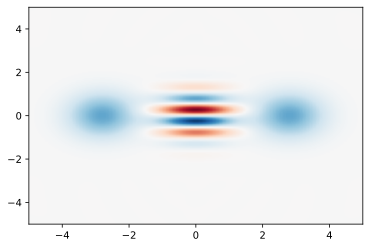

In [65]:
import qutip as qt

## Create quantum circuit
qc = QubitCircuit(N=1)
arg = np.pi
qc.add_gate("RZ", 0, None, arg)
    
init_state = (up+down).unit()
result = kpo.run_state(init_state=init_state, qc=qc, noisy=False)
states = result.states

def wigner_function(psi, xvec, yvec):
    X, Y = np.meshgrid(xvec, yvec)
    W = qt.wigner(psi, xvec, yvec)
    return X, Y, W

def update(frame):
    psi = result.states[frame]
    X, Y, W = wigner_function(psi, xvec, yvec)
    wigner.set_data(W)
    return wigner,

N = 50
xvec = np.linspace(-5, 5, 100)
yvec = xvec

fig, ax = plt.subplots()
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
W = wigner_function(result.states[0], xvec, yvec)[2]
nrm = mpl.colors.Normalize(-W.max(), W.max())
wigner = ax.imshow(W, extent=[-5, 5, -5, 5], origin="lower", aspect="auto", cmap=cm.RdBu, norm=nrm)

num_steps = len(result.times)
frames = range(num_steps)
t = 5*10**3 # length of video in milliseconds
interval = t / num_steps # delay between frames
ani = FuncAnimation(fig, update, frames=num_steps, blit=False, interval=interval)
ani.save("rz_gate.mp4")

plt.show()

### RX-gate

In [32]:
avg_fid = []
## List of angles
arg_list = np.linspace(0,np.pi,20,endpoint=False)

## Loop over the list of angles and calculate the average gate fidelity
for arg in arg_list:
    ## Create quantum circuit
    qc = QubitCircuit(N=1)
    qc.add_gate("RX", 0, None, arg)
    arg = arg % (np.pi)
    ## Ideal gate
    U = (-1j*arg/2*sigma_x).expm()
    
    ## Average Gate Fidelity
    d = 2
    F = 0
    for sigma_k in sigma:
        ## Master equation
        result = kpo.run_state(init_state=sigma_k, qc=qc, noisy=True)
        final_state = result.states[-1]
        ## Target state
        target_state = U * sigma_k * U.dag()
        F += (target_state * final_state).tr().real
    
    avg_fid.append(1/2 + 1/12 * F)

In [33]:
np.mean(avg_fid)

0.9859761249934532

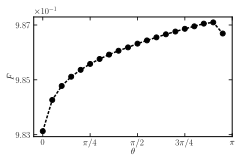

In [34]:
fig, ax = plot_lib.create_fig()
ax.plot(arg_list, avg_fid,'ko',linestyle=(0, (2, 1)))
ax.set_xlabel(r'$\theta$');
ax.set_ylabel(r'$\bar F$');
ax.set_xlim([-0.15,pi])
ax.set_xticks([0,pi/4,pi/2,3*pi/4,pi])
ax.set_yticks([9.83e-1,9.85e-1,9.87e-1])
ax.set_xticklabels([r'$0$',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$'])
# Format the exponents nicely
ax.ticklabel_format(axis="y", style="sci", scilimits=(-0,-7), useOffset=False, useMathText=False)

In [93]:
fig.savefig('fig-avg-gate-fid-rx.pdf', dpi=300, transparent=False, bbox_inches='tight')

### Test Plot

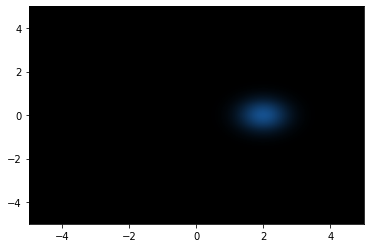

In [9]:
%matplotlib inline
import qutip as qt

## Create quantum circuit
qc = QubitCircuit(N=1)
arg = np.pi/2
qc.add_gate("RX", 0, None, arg)
    
init_state = up
result = kpo.run_state(init_state=init_state, qc=qc, noisy=False)

def wigner_function(psi, xvec, yvec):
    X, Y = np.meshgrid(xvec, yvec)
    W = qt.wigner(psi, xvec, yvec, 'iterative', 2)
    return X, Y, W

def update(frame):
    psi = result.states[frame]
    X, Y, W = wigner_function(psi, xvec, yvec)
    wigner.set_data(W)
    return wigner,

xvec = np.linspace(-5, 5, 200)
yvec = xvec

fig, ax = plt.subplots()
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
W = wigner_function(result.states[0], xvec, yvec)[2]
nrm = mpl.colors.Normalize(-W.max(), W.max())
cmap = colors.LinearSegmentedColormap.from_list(
    'custom_RdBu', [(0, cm.RdBu(0)), (0.5, 'black'), (1, cm.RdBu(240))])
wigner = ax.imshow(W, extent=[-5, 5, -5, 5], origin="lower", aspect="auto", cmap=cmap, norm=nrm)
plt.show()

### Make animation

In [ ]:
import qutip as qt

## Create quantum circuit
qc = QubitCircuit(N=1)
arg = np.pi/2
qc.add_gate("RX", 0, None, arg)
    
init_state = up
result = kpo.run_state(init_state=init_state, qc=qc, noisy=False)

def wigner_function(psi, xvec, yvec):
    X, Y = np.meshgrid(xvec, yvec)
    W = qt.wigner(psi, xvec, yvec)
    return X, Y, W

def update(frame):
    psi = result.states[frame]
    X, Y, W = wigner_function(psi, xvec, yvec)
    wigner.set_data(W)
    return wigner,

xvec = np.linspace(-5, 5, 100)
yvec = xvec

fig, ax = plt.subplots()
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
W = wigner_function(result.states[0], xvec, yvec)[2]
nrm = mpl.colors.Normalize(-W.max(), W.max())
cmap = colors.LinearSegmentedColormap.from_list(
    'custom_RdBu', [(0, cm.RdBu(0)), (0.5, 'black'), (1, cm.RdBu(240))])
wigner = ax.imshow(W, extent=[-5, 5, -5, 5], origin="lower", aspect="auto", cmap=cmap, norm=nrm)

num_steps = len(result.times)
frames = range(num_steps)
t = 5*10**3 # length of video in milliseconds
interval = t / num_steps # delay between frames
ani = FuncAnimation(fig, update, frames=num_steps, blit=False, interval=interval)

In [12]:
ani.save("rx_gate.mp4", dpi=300)

## RY-gate

(<Figure size 864x432 with 1 Axes>,
 <AxesSubplot:xlabel='Time (1/K)', ylabel='Amplitude (K)'>)

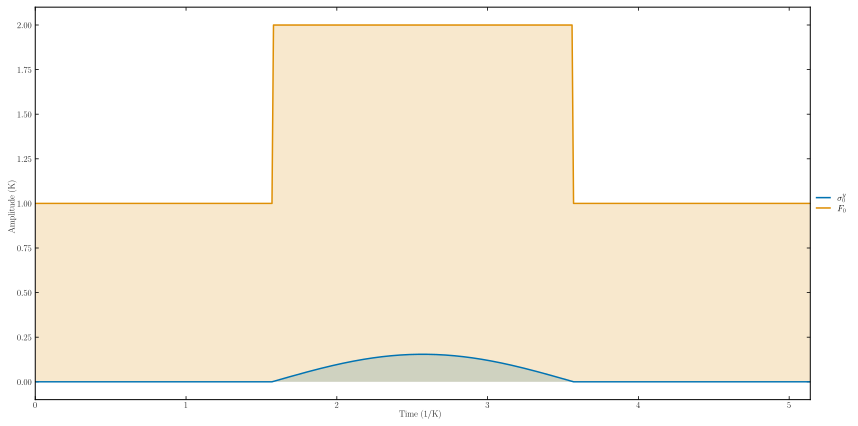

In [26]:
## Create quantum circuit
qc = QubitCircuit(N=1)
qc.add_gate("RY", 0, None, arg)

tlist, coeffs = kpo.load_circuit(qc)
kpo.plot_pulses()

In [27]:
avg_fid = []
## List of angles
arg_list = np.linspace(0,np.pi,10)
# For precise calculation
opt = Options(nsteps=25000, atol=1e-10, rtol=1e-8)

## Loop over the list of angles and calculate the average gate fidelity
for arg in arg_list:
    ## Create quantum circuit
    qc = QubitCircuit(N=1)
    qc.add_gate("RY", 0, None, arg)
    
    ## Ideal gate
    U = (-1j*arg/2*sigma_y).expm()
    
    ## Average Gate Fidelity
    F = 0
    for sigma_k in sigma:
        ## Master equation
        result = kpo.run_state(init_state=sigma_k, qc=qc, noisy=True, options=opt)
        final_state = result.states[-1]
        ## Target state
        target_state = U * sigma_k * U.dag()
        F += (target_state * final_state).tr().real
    avg_fid.append(1/2 + 1/12 * F)

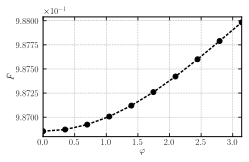

In [31]:
fig, ax = plot_lib.create_fig()
ax.plot(arg_list, avg_fid, 'ko',linestyle=(0, (2, 1)))

ax.set_xlabel(r'$\varphi$');
ax.set_ylabel(r'$\bar F$');
ax.grid(linestyle='--', linewidth=.5)
# Format the exponents nicely
ax.ticklabel_format(axis="y", style="sci", scilimits=(-0,-7), useOffset=False, useMathText=False)

### setup parameters for the two-qubit gates

In [75]:
## KPO parameters
kpo = KPOProcessor(N=2,num_lvl=12)
alpha = kpo._paras['Coherent state']
num_lvl = kpo._paras['Cut off']

## Cat state
cat_plus = (coherent(num_lvl,alpha) + coherent(num_lvl,-alpha)).unit()
cat_minus = (coherent(num_lvl,alpha) - coherent(num_lvl,-alpha)).unit()

## Computational basis
up = (cat_plus + cat_minus)/np.sqrt(2) # Binary 0
down = (cat_plus - cat_minus)/np.sqrt(2) # Binary 1

## Pauli Matrices in computational basis
# Identity
I = up*up.dag() + down*down.dag()
# sigma z
sigma_z = up*up.dag() - down*down.dag()
# sigma x
sigma_x = up*down.dag() + down*up.dag()
# sigma y
sigma_y = 1j*(-up*down.dag() + down*up.dag())
sigma = [I,sigma_x, sigma_y, sigma_z]

In [58]:
f = [] # fidelity

# initial state
psi0 = tensor([up-1j*down,up+1j*down]).unit()
Theta_list = np.linspace(0,np.pi,6)

# ideal gate
def U(Theta):
    return (-1j*Theta/2*tensor(sigma_z,sigma_z)).expm()

for Theta in Theta_list:
    ## Create quantum circuit
    qc = QubitCircuit(N=1)
    qc.user_gates = {"CARB": carb}
    qc.add_gate("CARB", targets = [0,1], arg_value = Theta)
    
    res = kpo.run_state(init_state=psi0, qc=qc, noisy=False)
    final_state = res.states[-1]
    target_state = U(Theta) * psi0
    f.append(fidelity(target_state,final_state))
f

[0.9919247983217977,
 0.9921972744132928,
 0.9929818406841681,
 0.9940948697456381,
 0.9952825153401887,
 0.9962862152791142]

In [59]:
target_state

Quantum object: dims = [[12, 12], [1, 1]], shape = (144, 1), type = ket
Qobj data =
[[ 0.        -0.01839294j]
 [ 0.03663161+0.j        ]
 [ 0.        -0.05202305j]
 [ 0.05981947+0.j        ]
 [ 0.        -0.06006958j]
 [ 0.05351005+0.j        ]
 [ 0.        -0.04384795j]
 [ 0.03309019+0.j        ]
 [ 0.        -0.02326614j]
 [ 0.01601111+0.j        ]
 [ 0.        -0.00891425j]
 [ 0.00784773+0.j        ]
 [-0.03663161+0.j        ]
 [ 0.        -0.07295595j]
 [-0.10360973+0.j        ]
 [ 0.        -0.11913717j]
 [-0.11963529+0.j        ]
 [ 0.        -0.10657125j]
 [-0.08732809+0.j        ]
 [ 0.        -0.06590281j]
 [-0.04633713+0.j        ]
 [ 0.        -0.03188792j]
 [-0.01775373+0.j        ]
 [ 0.        -0.01562963j]
 [ 0.        -0.05202305j]
 [ 0.10360973+0.j        ]
 [ 0.        -0.14714325j]
 [ 0.16919484+0.j        ]
 [ 0.        -0.16990225j]
 [ 0.15134912+0.j        ]
 [ 0.        -0.12402059j]
 [ 0.09359309+0.j        ]
 [ 0.        -0.06580652j]
 [ 0.04528622+0.j        

In [67]:
(1j*drift*2).expm() * final_state

Quantum object: dims = [[12, 12], [1, 1]], shape = (144, 1), type = ket
Qobj data =
[[ 0.00149169-0.01598045j]
 [ 0.03561955+0.01053001j]
 [ 0.00603405-0.04688207j]
 [ 0.05946279+0.01532719j]
 [ 0.0056143 -0.05434697j]
 [ 0.05321135+0.01384504j]
 [ 0.00611421-0.0386979j ]
 [ 0.03293659+0.00834832j]
 [ 0.00499505-0.01929289j]
 [ 0.01563842+0.0024531j ]
 [ 0.00198546-0.00888826j]
 [ 0.00331845-0.00048219j]
 [-0.03561955-0.01053001j]
 [ 0.04127307-0.06888294j]
 [-0.10058651-0.03140171j]
 [ 0.06397123-0.11289054j]
 [-0.11475852-0.03325229j]
 [ 0.05673436-0.10109493j]
 [-0.08266966-0.02455423j]
 [ 0.03494591-0.06178107j]
 [-0.04345767-0.01060619j]
 [ 0.01871716-0.02783751j]
 [-0.015304  -0.00255939j]
 [ 0.00881242-0.01302767j]
 [ 0.00603405-0.04688207j]
 [ 0.10058651+0.03140171j]
 [ 0.01895568-0.13507541j]
 [ 0.16537613+0.04834314j]
 [ 0.02219444-0.15570603j]
 [ 0.14872057+0.04170698j]
 [ 0.01841283-0.11132669j]
 [ 0.09127753+0.02500286j]
 [ 0.01175375-0.05865527j]
 [ 0.04293985+0.00772194j

In [5]:
def carb(arg_value):
    # control arbitrary phase gate
    zz = tensor(sigmaz(),sigmaz())
    return (-1j*arg_value/2*zz).expm()

In [76]:
avg_fid = []
## List of angles
arg_list = np.linspace(0,np.pi,1)

## Loop over the list of angles and calculate the average gate fidelity
for i, arg in enumerate(arg_list):
    ## Create quantum circuit
    qc = QubitCircuit(N=1)
    qc.user_gates = {"CARB": carb}
    qc.add_gate("CARB", targets = [0,1], arg_value = arg)
    
    ## Ideal gate
    U = (-1j*arg*tensor(sigma_z,sigma_z)/2).expm()
    
    # Progress bar
    progress = i / len(arg_list)
    print('%i %%'%(progress))
    
    ## Average Gate Fidelity
    d = 4
    F = 0
    for sigma_k in sigma:
        for sigma_l in sigma:
            sigma_kl = tensor(sigma_k,sigma_l)
            ## Master equation
            result = kpo.run_state(init_state=sigma_kl, qc=qc, noisy=False)
            drift = kpo.drift.drift_hamiltonians[0].qobj
            rot = (1j*drift*2).expm()
            final_state = rot * result.states[-1] * rot.dag()
            ## Target state
            target_state = U * sigma_kl.dag() * U.dag()
            F += abs((target_state * final_state).tr())
    avg_fid.append((F + d**2) / (d**2*(d+1)))

0 %


### Test

In [ ]:
fun

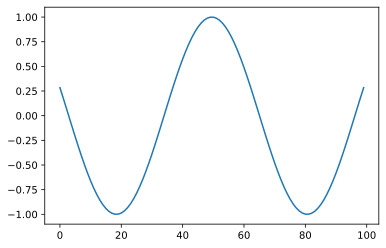

In [102]:
k = 1
omega = 1
xvec = np.linspace(-5, 5, 100)

def fun(t):
    return np.exp(1j*(k*xvec-omega*t)).real

def update(frame):
    return fun(frame)

fig, ax = plt.subplots()
#ax.set_xlim(0, 1)
ax.set_ylim(-1.1, 1.1)
ax.plot(fun(0))

t_total = 5*10**3 # length of video in milliseconds
num_steps = 100
frames = range(int(t_total/10**3))
interval = t_total / num_steps # delay between frames
ani = FuncAnimation(fig, update, frames=frames, blit=False)
ani.save("test.mp4")

plt.show()

In [98]:
frames

range(0, 100)

In [ ]:
t_total

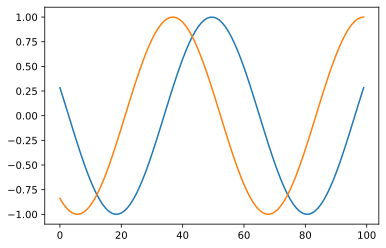

In [91]:
plt.plot(fun(xvec,0))
plt.plot(fun(xvec,5))

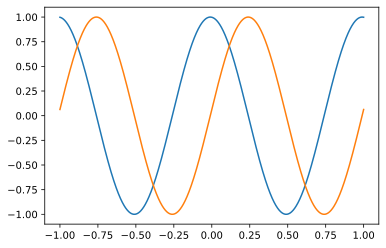

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Set wave parameters
freq = 1 # Hz
wavelength = 1 # m
k = 2 * np.pi / wavelength

# Set time interval
dt = 0.01 # sec
t_final = 5 # sec
times = np.arange(0, t_final, dt)

# Define plane wave
def plane_wave(x, t, y):
    if y:
        return np.exp(1j*(k*x-2*np.pi*freq*t)).real
    else:
        return np.exp(1j*(k*x-2*np.pi*freq*t)).imag

# Create animation
fig, ax = plt.subplots()
x = np.linspace(-wavelength, wavelength, 1000)
line_real, = ax.plot(x, plane_wave(x, 0, True))
line_imag, = ax.plot(x, plane_wave(x, 0, False))

def animate(i):
    line_real.set_ydata(plane_wave(x, times[i], True))
    line_imag.set_ydata(plane_wave(x, times[i], False))
    return line_real, line_imag

ani = FuncAnimation(fig, animate, frames=len(times), interval=100, blit=True)
ani.save("right_moving_wave.mp4")
plt.show()

In [29]:
cm.RdBu.from_list

TypeError: from_list() missing 2 required positional arguments: 'name' and 'colors'

In [27]:
dir(cm.RdBu)

['N',
 '__call__',
 '__class__',
 '__copy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_gamma',
 '_global',
 '_i_bad',
 '_i_over',
 '_i_under',
 '_init',
 '_isinit',
 '_lut',
 '_repr_html_',
 '_repr_png_',
 '_resample',
 '_reverser',
 '_rgba_bad',
 '_rgba_over',
 '_rgba_under',
 '_segmentdata',
 '_set_extremes',
 'colorbar_extend',
 'copy',
 'from_list',
 'get_bad',
 'get_over',
 'get_under',
 'is_gray',
 'monochrome',
 'name',
 'reversed',
 'set_bad',
 'set_extremes',
 'set_gamma',
 'set_over',
 'set_under',
 'with_extremes']

In [43]:
cm.RdBu(500)

(0.0196078431372549, 0.18823529411764706, 0.3803921568627451, 1.0)

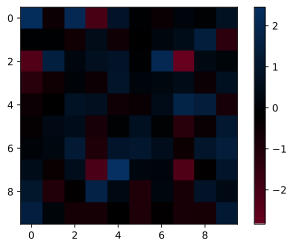

In [54]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import numpy as np

# Define the colormap with black instead of white around 0 and same shades of blue and red
cmap = colors.LinearSegmentedColormap.from_list(
    'custom_RdBu', [(0, cm.RdBu(0)), (0.5, 'black'), (1, cm.RdBu(1000))])

# Generate some random data to plot
data = np.random.randn(10, 10)

# Plot the data using the custom colormap
plt.imshow(data, cmap=cmap)

# Add a colorbar to show the mapping of values to colors
plt.colorbar()

# Show the plot
plt.show()
